Most AI of autonmous vehicles (AVs) comes not standalone but rather with a large number of rules ans heuristics that restrict what actions the AI takes or can take. This primarily relates to managing risks, such as those resulting from collisions or crashes.

There are number of standard risk measures that are typically used, such as (trailing) stop loss orders or take profit orders. How such risk measures are handles is a matter of human judgement. AI provides improved predictions, but human judgement still plays a role in setting decision rules and action boundaries.

First, it backtests in both vectorized and event-based fashio algorithm trading strategies that result from a trained deep Q-learning agent called trading bots.

Second, it assesses risks related to the financial instrument on which the strategies are implemented on which the strategies are implemented.

Third, it backtests typical risk measures using the event-based approach. The major benefit of event-based backtesting when compared to vectorized backtesting is higher degree of flexibility in modeling and analyzing decision rule and risk management measures.

# Trading Bot

This section presents a trading bot based on the financial Q-learning agent, `FQLAgent`.

In [2]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl

import warnings
warnings.filterwarnings('ignore')

We use `finance` class and `tradingbot` class

In [3]:
%load_ext autoreload
%autoreload 2
import finance
import tradingbot

In [4]:
symbol = "EUR="
features = [symbol, 'r', 's', 'm', 'v']

In [5]:
a = 0
b = 1750
c = 250

In [7]:
learn_env = finance.Finance(symbol, features, window=20, lags=3,
                            leverage=1, min_performance=0.9, min_accuracy=0.475,
                            start=a, end=a+b, mu=None, std=None)

In [8]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1750 entries, 2010-02-02 to 2017-01-12
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    1750 non-null   float64
 1   r       1750 non-null   float64
 2   s       1750 non-null   float64
 3   m       1750 non-null   float64
 4   v       1750 non-null   float64
 5   d       1750 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 88.9 KB


In [9]:
valid_env = finance.Finance(symbol, features=learn_env.features,
                            window=learn_env.window,
                            lags=learn_env.lags,
                            leverage=learn_env.leverage,
                            min_performance=0.0, min_accuracy=0.0,
                            start=a+b, end=a+b+c,
                            mu=learn_env.mu, std=learn_env.std)

In [10]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2017-01-13 to 2018-01-10
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    250 non-null    float64
 1   r       250 non-null    float64
 2   s       250 non-null    float64
 3   m       250 non-null    float64
 4   v       250 non-null    float64
 5   d       250 non-null    int32  
dtypes: float64(5), int32(1)
memory usage: 12.7 KB


In [11]:
tradingbot.set_seeds(100)
agent = tradingbot.TradingBot(24, 0.001, learn_env, valid_env)

In [12]:
episodes = 61

In [14]:
%time agent.learn(episodes)

episode: 10/61 | VALIDATION | treward:  247 | perf: 1.126 | eps: 0.90
episode: 20/61 | VALIDATION | treward:  247 | perf: 1.067 | eps: 0.82
episode: 30/61 | VALIDATION | treward:  247 | perf: 0.980 | eps: 0.74
episode: 40/61 | VALIDATION | treward:  247 | perf: 0.965 | eps: 0.67
episode: 50/61 | VALIDATION | treward:  247 | perf: 0.973 | eps: 0.61
episode: 60/61 | VALIDATION | treward:  247 | perf: 0.967 | eps: 0.55
episode: 61/61 | treward: 1747 | perf: 2.143 | av: 761.2 | max: 1747
CPU times: total: 1.17 s
Wall time: 35.8 s


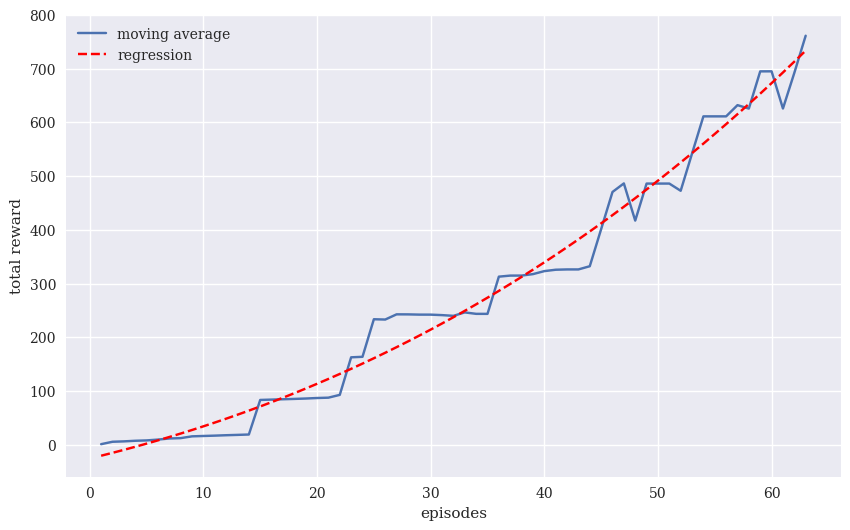

In [15]:
tradingbot.plot_treward(agent)

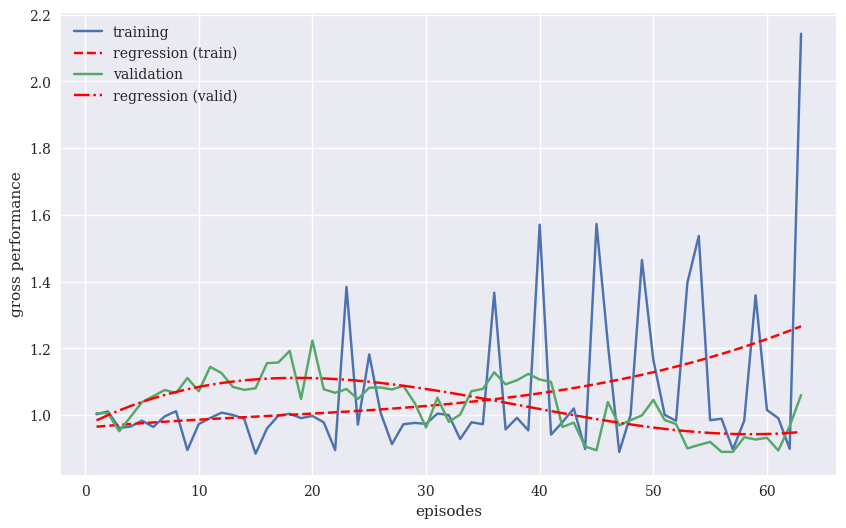

In [16]:
tradingbot.plot_performance(agent)

# Vectorized Backtesting

In DNN context, the data with the feature and labels sub-sets is prepared first and then fed to the DNN to generate all predictions at once. In a reinforcement learning (RL) context, data is generated and collected by interacting with the environment action by action and step by step.

In [17]:
def reshape(s):
    # reshape a single feature-label combination
    return np.reshape(s, [1, learn_env.lags, learn_env.n_features])

In [18]:
def backtest(agent, env):
    env.min_accuracy = 0.0
    env.min_performance = 0.0
    done = False
    # generates a column for the position values
    env.data['p'] = 0
    state = env.reset()
    while not done:
        action = np.argmax(
            # derives the optimal action (prediction) given the trained DNN
            agent.model.predict(reshape(state))[0, 0]
        )
        # derives the resulting position (+1 for long/upwards, -1 for short/downwards)
        position = 1 if action == 1 else -1
        # stores in the corresponding column at the appropriate index position
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action)
    # calculates the strategy log return given the position values
    env.data['s'] = env.data['p'] * env.data['r'] * learn_env.leverage

In [19]:
# specifies the relevant environment
env = agent.learn_env

In [20]:
# generates the additional data required
backtest(agent, env)

In [21]:
# counts the number of long and short positions
env.data['p'].iloc[env.lags:].value_counts()

p
-1    1123
 1     624
Name: count, dtype: int64

In [22]:
# calculates the gross performances for the passive benchmark investment (r) and the strategy (s)
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r    0.772535
s    2.615251
dtype: float64

In [23]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

r   -0.227465
s    1.615251
dtype: float64

<Axes: xlabel='Date'>

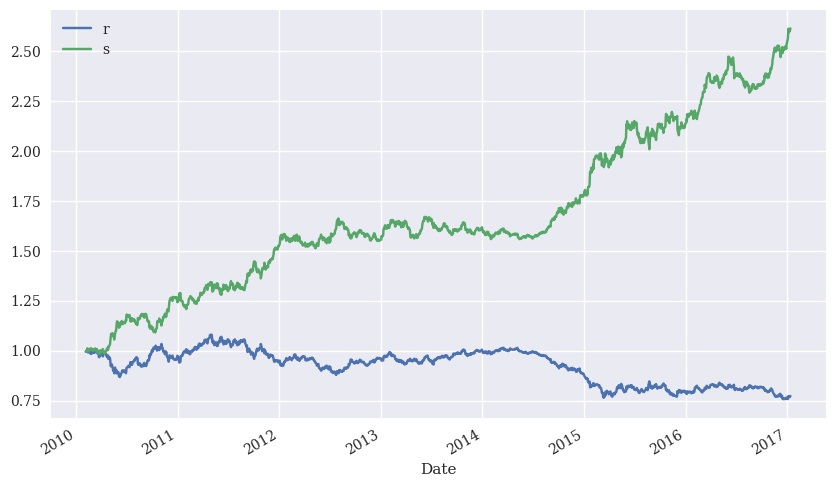

In [24]:
env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6))

To get a more realistic picture of the performance of the trading bot, the following code creates a test environment with data that the trading bot has not yet seen.

In [25]:
test_env = finance.Finance(symbol, features=learn_env.features,
                           window=learn_env.window,
                           lags=learn_env.lags,
                           leverage=learn_env.leverage,
                           min_performance=0.0, 
                           min_accuracy=0.0,
                           start=a+b+c, end=None,
                           mu=learn_env.mu, std=learn_env.std)

In [26]:
env = test_env

In [27]:
backtest(agent, env)

In [28]:
env.data['p'].iloc[env.lags:].value_counts()

p
-1    439
 1     54
Name: count, dtype: int64

In [29]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r    0.914430
s    1.131884
dtype: float64

In [30]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

r   -0.085570
s    0.131884
dtype: float64

<Axes: xlabel='Date'>

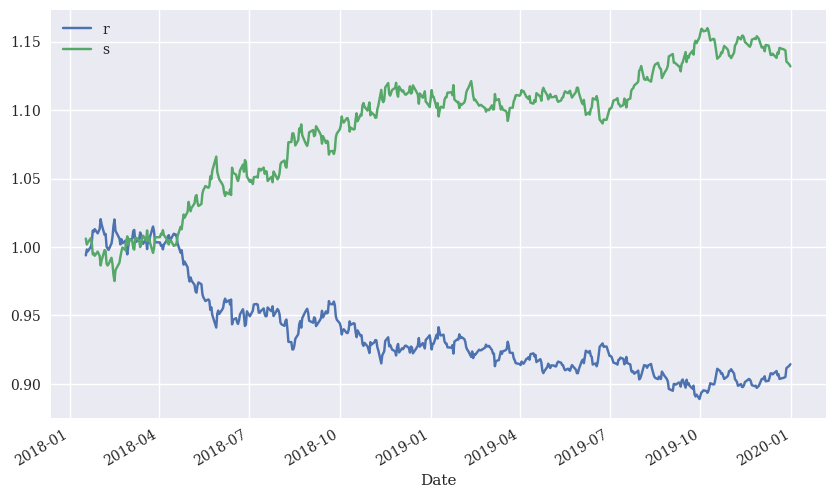

In [31]:
env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6))

To be able to judge the real performance of a trading strategy, risk measures should be included. 

# Event-Based Backtesting

To be able to properly analyze risk measures, such as trailing stop loss orders, event-based backtesting is required.

`get_date_price()`
For a given bar (index value for the DataFrame object containing the financial data), it returns the relevant date and price.

`print_balance()`
For a given bar, it prints the current (cash) balance of the trading bot.

`calculate_net_wealth()`
For a given price, it returns the net wealth composed of the current (cash) balance and the instrument position.

`print_net_wealth()`
For a given bar, it prints the net wealth of the trading bot.

`place_but_order()`, `place_sell_order()`
For a given bar and a given number of units or a given amount, these methods place buy or sell orders and adjust relevant quantities accordingly.

`close_out()`
At a given bar, this method closes open postions and calculates and reports performance statistics.



In [32]:
import backtesting as bt

In [33]:
# instantiates a Backtesting object
bb = bt.BacktestingBase(env=agent.learn_env, model=agent.model,
                        amount=10000, ptc=0.0001, ftc=1.0, verbose=True)

In [34]:
# initial amount attribute
bb.initial_amount

10000

In [35]:
# fixes bar value
bar = 100

In [36]:
# retrieves the date and price values for the bar
bb.get_date_price(bar)

('2010-06-25', 1.2374)

In [37]:
# retrieves the state of the Finance environment for the bar
bb.env.get_state(bar)

,EUR=,r,s,m,v
Date,,,,,
2010-06-22,-0.024193,-0.562226,-0.091601,-0.202232,1.531581
2010-06-23,0.017620,0.693976,-0.093921,-0.091539,1.556293
2010-06-24,0.035412,0.303386,-0.086514,0.639094,1.089033


In [38]:
# places a buy order using the amount parameter
bb.place_buy_order(bar, amount=5000)

2010-06-25 | buy 4040 units for 1.2374
2010-06-25 | current balance = 5001.40


In [39]:
# prints the net wealth at a later point (2 * bar)
bb.print_net_wealth(2 * bar)

2010-11-16 | net wealth = 10452.17


In [40]:
# places a sell order at that later point using the units parameter
bb.place_sell_order(2 * bar, units=1000)

2010-11-16 | sell 1000 units for 1.3492
2010-11-16 | current balance = 6349.47


In [41]:
# closes out the remaining long position even later (3 * bar)
bb.close_out(3 * bar)

2011-04-11 | *** CLOSING OUT ***
2011-04-11 | sell 3040 units for 1.4434
2011-04-11 | current balance = 10735.97
2011-04-11 | net performance [%] = 7.3597
2011-04-11 | number of trades [#] = 3


In [51]:
# event-based backtesting for the trading bot
class TBBacktester(bt.BacktestingBase):
    def _reshape(self, state):
        '''
        helper method to reshape state objects
        '''
        return np.reshape(state, [1, self.env.lags, self.env.n_features])
    
    def backtest_strategy(self):
        '''
        Event-based backtesting of the trading bot's performance
        '''
        self.untis = 0
        self.position = 0
        self.trades = 0
        self.current_balance = self.initial_amount
        self.net_wealths = list()
        for bar in range(self.env.lags, len(self.env.data)):
            date, price = self.get_date_price(bar)
            if self.trades == 0:
                print(50 * '=')
                print(f'{date} | *** START BACKTEST ***')
                self.print_balance(bar)
                print(50 * '=')
            # retrieves the state of the Finance environment
            state = self.env.get_state(bar)
            # generates the optimal action (prediction) given the state and the model object
            action = np.argmax(self.model.predict(self._reshape(state.values))[0, 0])
            # derives the optimal postion (long/short) given the optimal action (prediction)
            position = 1 if action == 1 else -1
            # enters a long positoin if the conditions are met
            if self.position in [0, -1] and position == 1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING LONG ***')
                if self.position == -1:
                    self.place_buy_order(bar - 1, units=-self.units)
                    self.place_buy_order(bar - 1,
                                         amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = 1
            
            # enters a short position if the conditions are met
            elif self.position in [0, 1] and position == -1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING SHORT ***')
                if self.position == 1:
                    self.place_sell_order(bar - 1, units=self.units)
                self.place_sell_order(bar - 1, amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = -1
            
            # collects the net wealth values over time and transforms them into a DataFrame object
            self.net_wealths.append((date, self.calculate_net_wealth(price)))
        self.net_wealths = pd.DataFrame(self.net_wealths, columns=['date', 'net_wealth'])
        self.net_wealths.set_index('date', inplace=True)
        self.net_wealths.index = pd.DatetimeIndex(self.net_wealths.index)
        self.close_out(bar)  
                    

In [52]:
env = learn_env

In [53]:
# event-based backtest in-sample without transaction costs
tb = TBBacktester(env, agent.model, 10000, 0.0, 0, verbose=False)

In [54]:
tb.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2010-02-08 | *** START BACKTEST ***
2010-02-08 | current balance = 10000.00
2010-02-09 | *** START BACKTEST ***
2010-02-09 | current balance = 10000.00
2010-02-10 | *** START BACKTEST ***
2010-02-10 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 24927.44
2017-01-12 | net performance [%] = 149.2744
2017-01-12 | number of trades [#] = 849


In [55]:
# event-based backtest in-sample with transaction costs
tb_ = TBBacktester(env, agent.model, 10000, 0.00012, 0.0, verbose=False)

In [56]:
tb_.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2010-02-08 | *** START BACKTEST ***
2010-02-08 | current balance = 10000.00
2010-02-09 | *** START BACKTEST ***
2010-02-09 | current balance = 10000.00
2010-02-10 | *** START BACKTEST ***
2010-02-10 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 24924.89
2017-01-12 | net performance [%] = 149.2489
2017-01-12 | number of trades [#] = 849


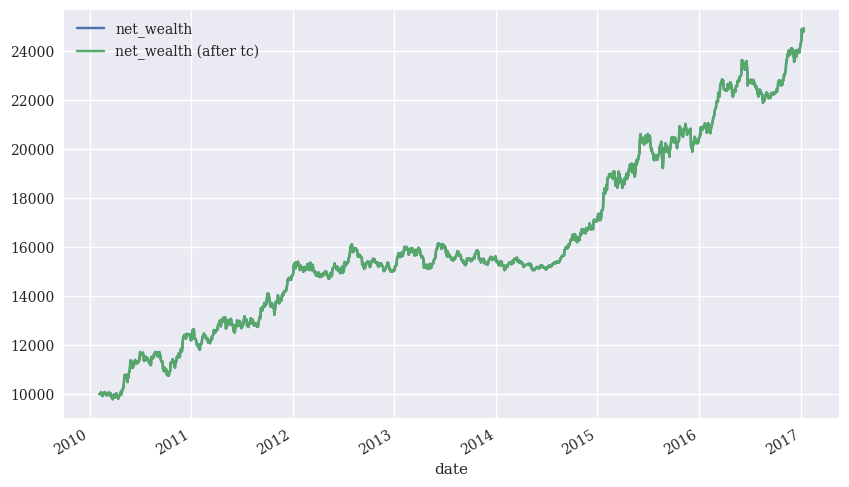

In [57]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);

In [58]:
# event-based backtest out-of-sample
env = test_env

In [59]:
# event-based backtest out-of-sample without transaction costs
tb = TBBacktester(env, agent.model, 10000, 0.0, 0, verbose=False)
tb.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 34396.41
2019-12-31 | net performance [%] = 243.9641
2019-12-31 | number of trades [#] = 126


In [60]:
tb_ = TBBacktester(env, agent.model, 10000, 0.00012, 0.0, verbose=False)
tb_.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 34393.49
2019-12-31 | net performance [%] = 243.9349
2019-12-31 | number of trades [#] = 126


<Axes: xlabel='date'>

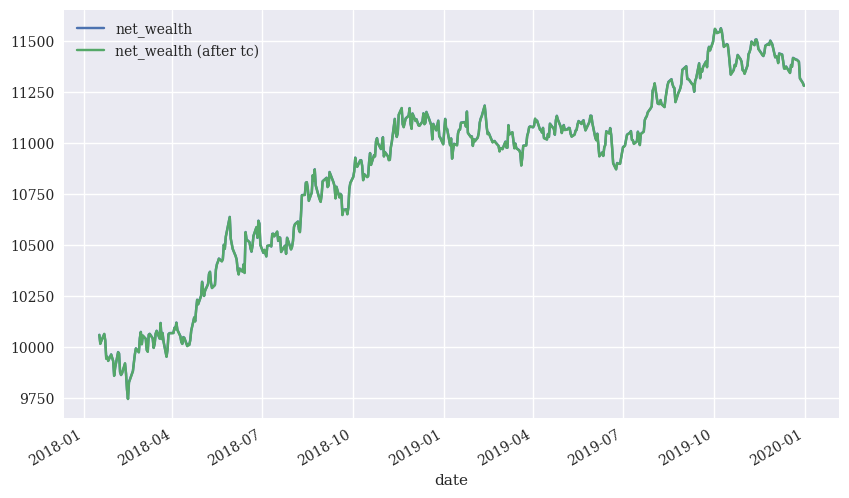

In [61]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax)

The performance difference can be mainly explained by the fact that the event-based backtesting assumes the same amount for every position taken. Vectorized backtesting takes compound effects into account, leading to a slightly higher reported performance.

<Axes: xlabel='Date'>

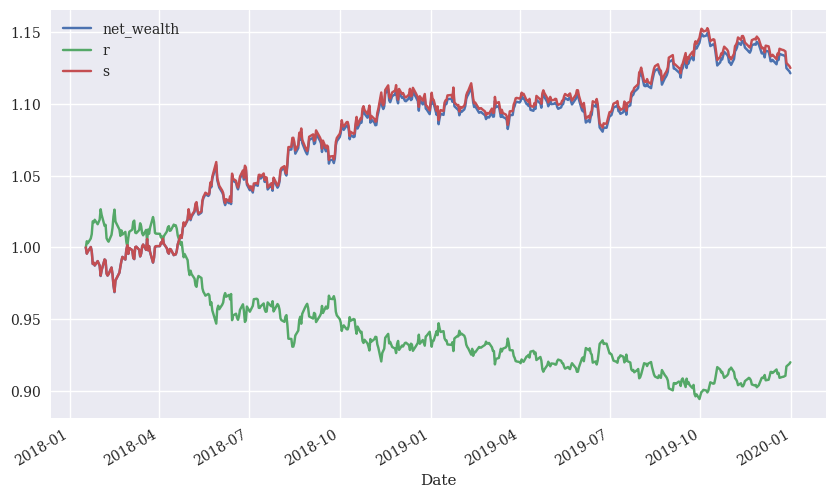

In [62]:
ax = (tb.net_wealths / tb.net_wealths.iloc[0]).plot(figsize=(10, 6))
tp = env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp)
(tp / tp.iloc[0]).plot(ax=ax)

### Performance differences

The performance numbers from the vectorized and the event-based backtesting are close but are not exactly the same. In the first case, it is assumed that financial instruments are perfectly divisible. Compouding is also done continuously. In the later case, only full units of the financial instrument are accepted for trading.

The net wealth calculations are based on price differences. The event-based code doen not check whether the current balance is large enough to cover a certain trade by cash.

# Assesing Risk

To properly set parametes for risk measure, such as stop loss orders, an assessment of the risk of the underlying instrument is importnant.  There are many approaches available to measure the risk of a financial instrument. There are nondirected risk measures, such as volitility or average true range (ATR). There are also directed measures, such as maximum drawdown or value-at-risk (VaR).

A common practice when setting target levels for stop loss (SL), trailing stop loss (TSL), or take profit orders (TP) is to relate such levels to ATR values.

In [63]:
# the instrument price column from the original `DataFrmae` object.
data = pd.DataFrame(learn_env.data[symbol])
data.head()

,EUR=
Date,
2010-02-02,1.3961
2010-02-03,1.3898
2010-02-04,1.3734
2010-02-05,1.3662
2010-02-08,1.3652


In [64]:
# the window length to be used for the calculation
window = 14

In [65]:
# the rolling minimum
data['min'] = data[symbol].rolling(window).min()

In [66]:
# the rolling maximum
data['max'] = data[symbol].rolling(window).max()

In [67]:
# the difference between rolling maximum and minimum
data['mami'] = data['max'] - data['min']

In [68]:
# the absolute difference between rolling maximum and previous day's price
data['mac'] = abs(data['max'] - data[symbol].shift(1))

In [69]:
# the absolute difference between rolling minumum and previous day's price
data['mic'] = abs(data['min'] - data[symbol].shift(1))

In [70]:
# the maximum of the max-min difference and the max-price difference
data['atr'] = np.maximum(data['mami'], data['mac'])

In [71]:
# the maximum between the previous maximum and the min-price difference (=ATR)
data['atr'] = np.maximum(data['atr'], data['mic'])

In [72]:
# the ATR value in percent from the absolute ATR value and the price
data['atr%'] = data['atr'] / data[symbol]

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

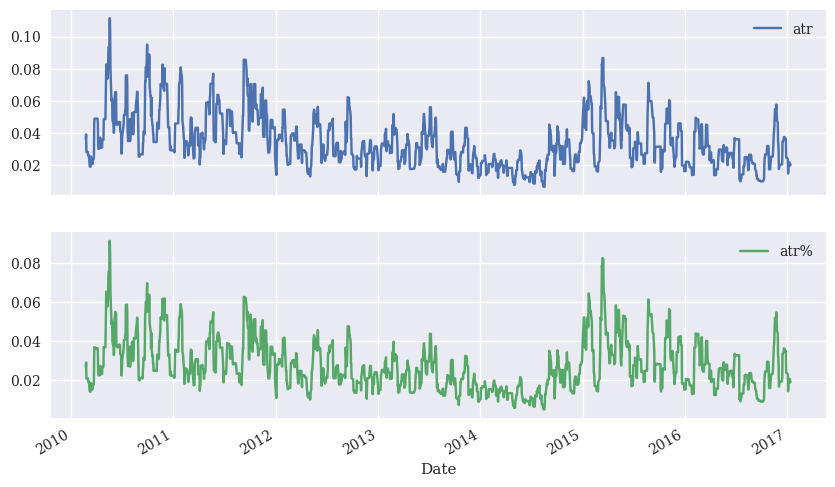

In [73]:
data[['atr', 'atr%']].plot(subplots=True, figsize=(10, 6))

A typical rule would be to set the SL level at the entry price minus $x$ time ATR. Depending on the risk appetite of the trader or investor, $x$ might be smaller thatn 1 or larger.

This is where human judgement or formal risk policies come into play. If $x=1$, then the SL level is set at about 2% below the entry level.

In [74]:
data[['atr', 'atr%']].tail()

,atr,atr%
Date,,
2017-01-06,0.0218,0.020703
2017-01-09,0.0218,0.020621
2017-01-10,0.0218,0.020658
2017-01-11,0.0199,0.018809
2017-01-12,0.0206,0.019416


Leverage plays an important role in this context. If a leverage of 10 is used, which is actually quite low for foreign exchange trading, then the ATR numbers need to be multiplied by the leverage. As a consequence, for an assumed ATR factor of 1, the same SL level from before now is to be set at about 20% instead of just 2%. When taking the median value of the ATR from the whole data set, it is set to be at about 25%.

In [76]:
leverage = 10

In [77]:
data[['atr', 'atr%']].tail() * leverage

,atr,atr%
Date,,
2017-01-06,0.218,0.207028
2017-01-09,0.218,0.206205
2017-01-10,0.218,0.206576
2017-01-11,0.199,0.188091
2017-01-12,0.206,0.194156


In [78]:
data[['atr', 'atr%']].median() * leverage

atr     0.318000
atr%    0.248082
dtype: float64

The basic idea behind relating SL or TP levels to ATR is that one should avoid setting them either too low or too high. Consider a 10 times leveraged position for which the ATR is 20%. Setting an SL level of only 3% or 5% might reduce the financial risk for the postiion, but it introduces the risk of a stop out that happens too early and that is due to typical movements in the financial instrument.

Such "typical movements" within certain ranges are often called noise. The SL order should protect, in general, from unfavorable market movements that are larger than typical price movements.

The same holds true for a take profit level. If it is set too high, say at three times the ATR positions might remain open for too long.

If financial context, there is quite a degree of freedom for setting such target levels, and human jedgement can come to the rescue. In other contexts, such as for AVs, this is different, as no human judgement is needed to instruct the AI to avoid any collisions with human beings. 

# Backtesting Risk Measures

A new backtesting class, `TBBacktesterRM` allows the inclustion of SL, TSL, and TP orders. The parameterization of the backtesting exmaples orients itself roughtly on an ATR level of about 2%, as calculated in the previous section.

### EUT and Risk Measures

EUT, MVP, and the CAPM assumes that financial agents know about the future distribution of the returns of a financial instrument. MPT and the CAPM assume furthermore that returns are normally distributed and that there is a linear relationship between the market portfolio's returns and the returns of a traded financial instrument. The use of SL, TSL, and TP orders leads - similar and in addition to leverage in combination with margin stop out - to a guaranteed nonnormal distribution and to highly asymmetric, nonlinear payoffs of a trading position in relation to the traded intrument.

## Stop Loss

The first risk measure is the SL order. It fixes a certain price level or, more often a fixed percent value that triggers the closing of a position. For example, if the entry price for an unleveraged position is 100 and the SL level is set up to 5%, then a long position is closed out at 95 while a short position is closed out at 105.

### Stop order / Limit order

#### Stop order

stop은 현재가보다 불리한 가격에 내는 주문을 말하고, limit는 현재가보다 유리한 가격에 내는 주문을 말한다.
<img src='./img/Definition-and-Difference-between-Stop-and-Limit-order.png'>


**(1) buy stop order**

현재 시장보다 높은 가격으로 주문을 한 후, 가격이 지정된 해당 수준에 도달하면 시장 주문이 시작되어, 다음 사용 가능한 가격으로부터 매수가 가능하다. 예를 들어 시장 가격이 48달러이고, 내가 50달러에 buy stop order를 설정해 두면, 시장 가격이 50달러에 도달했을 때, 거래가 시작되는 것이다. 그래서 거래 가격이 50달러가 될 수 있고, 그 이상이 될 수도 있다.

**(2) sell stop order**

현재 시장 가격보다 낮은 가격으로 주문을 한 후, 가격이 지정된 해당 수준에 도달하면 시장 주문이 시작되어, 다음 사용 가능한 가격으로부터 매도가 가능하다. 예를 들어 내가 주당 40달러에 주식을 매수하고, 거래에서 주당 5달러 이상의 손실을 원하지 않는다고 가정해보자. 주당 5달러 이상의 손실을 피하기 위해, 바로 35달러 아래인 34.50 달러에 sell stop 주문을 실행했다면, 주가가 하락해서 시장 가격이 34.50 달러에 도달했을 때, 셀 스탑 주문이 실행되어, 거래자의 주식은 다음 사용 가능한 시장 가격으로 판매된다.

### Limit order

**(1) buy limit order**
현재 시장 가격에 거래를 원하지 않고 현재가보다 낮은 가격으로 주문을 체결하고 싶을 때 사용한다. 내가 지정해 둔 가격에 시장 가격이 도달하면 거래가 체결된다.

**(2) sell limit order**
주식이 오르고 있을 때 현재 시장 가격보다 높은 가격에 주문을 체결하고 싶을 때 사용한다.

In [86]:
%load_ext autoreload
%autoreload 2
import tbbacktesterrm as tbbrm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
env = test_env

In [88]:
# instantiates the backtesting class for risk management
tb = tbbrm.TBBacktesterRM(env, agent.model, 10000, 0.0, 0, verbose=False)

In [89]:
# backtests the trading bot performance without any risk measure
tb.backtest_strategy(sl=None, tsl=None, tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 34396.41
2019-12-31 | net performance [%] = 243.9641
2019-12-31 | number of trades [#] = 126


In [90]:
# backtests the trading bot performance with an SL order (no guarantee)
tb.backtest_strategy(sl=0.0017, tsl=None, tp=None, wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.011909)
--------------------------------------------------
*** STOP LOSS (SHORT | -0.008710)
*** STOP LOSS (LONG | -0.0024) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.006901)
--------------------------------------------------
*** STOP LOSS (SHORT | -0.002676)
--------------------------------------------------
*** STOP LOSS (SHORT | -0.004902)
--------------------------------------------------
*** STOP LOSS (SHORT | -0.003819)
--------------------------------------------------
*** STOP LOSS (SHORT | -0.004889)
*** STOP LOSS (LONG | -0.0045) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.003263)
*** STOP LOSS (LONG | -0.0062) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.005060)
--------------------------------------------------
***

In [91]:
# backtests the trading bot performance with an SL order (with guarantee)
tb.backtest_strategy(sl=0.0017, tsl=None, tp=None, wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0017) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0017) ***
*** STOP LOSS (LONG | -0.0017) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0017) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0017) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0017) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0017) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0017) ***
*** STOP LOSS (LONG | -0.0017) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0017) ***
*** STOP LOSS (LONG | -0.0017) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0017) ***
------------------------------------

## Trailing Stop Loss

In contrast to a regular SL order, a TSL order is adjusted whenever a new high is observed after the the base order has been placed. Assume the base order for an unleveraged long position has an entry of 95 and the TSL is set to 5%. If the instrument price reaches 100 and falls back to 95, this implies a TSL event, and the position is closed at the entry price level. If the price reaches 110 and falls bavk to 104.5, this would imply another TSL event.

In [92]:
# backtests the trading bot performance with TSL order
tb.backtest_strategy(sl=None, tsl=0.0015, tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0033) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0016) ***
--------------------------------------------------
*** TRAILING SL (LONG | -0.0106) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0038) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0102) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0018) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0078) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0035) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0043) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0022) ***
-----------------------------------

As the backtesting results that using a TSL order with the given parameterization reduces the gross performance compared to a strategy without a TSL order in place.

## Take Profit

A TP order closes out a position that has reached a certain profit level. Say an unleveraged long position is opened at a price of 100 and the TP order is set to a level of 5%. If the price reaches 105, the position is closed.

For the TP order, there is also the option to backtest with a guaranteed price level as compared to the relevant high/low price levels, which would most probavly lead to performance values that are too optimistic.

For the given parameterization, adding a TP order - without guarantee - improves the trading bot performance noticeably comnpared to the passive benchmark investment. This result might be too optimistic given the considerations from before. Therefore, the TP order with guarantee leads to a more realistic performance value in this case.

In [93]:
# backtests the trading bot performance with a TP order (no guarantee)
tb.backtest_strategy(sl=None, tsl=None, tp=0.015, wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0175) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0213) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0214) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0154) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0158) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 35130.85
2019-12-31 | net performance [%] = 251.3085
2019-12-31 | number of trades [#] = 120


In [94]:
# backtests the trading bot performance with a TSL and TP order
tb.backtest_strategy(sl=None, tsl=None, tp=0.015, wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 36444.70
2019-12-31 | net performance [%] = 264.4470
2019-12-31 | number of trades [#] = 120


SL/TSL orders can be combined with TP orders. The backtest results are in both cases worse than those for the strategy without risk measures in place. In managing risk, there is any free lunch.

In [95]:
# backtests the trading bot performance with an SL and TP order
tb.backtest_strategy(sl=0.015, tsl=None, tp=0.0185, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.020228)
--------------------------------------------------
*** STOP LOSS (SHORT | -0.017411)
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0195) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0219) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0214) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.017806)
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0223) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.015040)
--------------------------------------------------
*** STOP LOSS (SHORT | -0.015234)
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0191) ***
--------------------------------------------------
*** STOP

In [96]:
# backtests the trading bot performance with a TSL and TP order
tb.backtest_strategy(sl=None, tsl=0.02, tp=0.02, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0202) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0263) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0227) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0214) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0206) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0223) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0223) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0211) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0201) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 40198.31
2019-12-31 | net performance [%] = 301.9831
2019-12-31 